In [1]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import glob, os, csv

# from langdetect import detect

# import gensim
# from gensim.utils import simple_preprocess
# from gensim import corpora, models
# from gensim.models import CoherenceModel

from pprint import pprint

# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# from nltk.stem import WordNetLemmatizer
# from nltk.stem import PorterStemmer
# from nltk.corpus import stopwords
# from nltk.corpus import wordnet
# stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'http', 'javascript', 'onion', 'site', 'com'])

from bs4 import BeautifulSoup

# import pyLDAvis
# import pyLDAvis.gensim

import ast
from collections import Counter
from operator import add
# from wordcloud import WordCloud

# import stanza
# # stanza.download('en')
# nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma')

from sklearn.model_selection import train_test_split
import math
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
import seaborn as sns
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [2]:
# Preprocessing

In [3]:
## Categories ##
# 1: Market: Drug, gun, 
# 2: Counterfeit: counterfeit credit cards, money, ID
# 3: Services: Hosting service, forum, email, pastebin, file-sharing
# 4: Security: Security-related information, tutorials or services, leaked data
# 5: Porn: Hosting pornographic material
# 6: Cryptocurrency
# 7: NoAccess: Login, Down, Empty
# 8: Other: Cannot be classified in any other category (e.g. personal blog)

In [4]:
# Dictionary of conversion of categories
conversion_dict = {
    'Art': 'Other',
    'Casino': 'Services',
    'Counterfeit Credit-Cards': 'Counterfeit',
    'Counterfeit Money': 'Counterfeit',
    'Counterfeit Personal-Identification': 'Counterfeit',
    'Cryptocurrency': 'Cryptocurrency',
    'Cryptolocker': 'Security',
    'Down': 'NoAccess',
    'Drugs': 'Market',
    'Empty': 'NoAccess',
    'Forum': 'Services',
    'Hacking': 'Security',
    'Hosting': 'Services',
    'Leaked-Data': 'Security',
    'Library': 'Other',
    'Locked': 'NoAccess',
    'Marketplace': 'Market',
#     'Onion Directory/Wiki': ['directory', 'dir', 'wiki'],
    'Personal': 'Other',
    'Politics': 'Other',
    'Porno': 'Porn',
    'Religion': 'Other',
    'Services': 'Services',
    'Social-Network': 'Services',
    'Violence': 'Market'
}

In [5]:
# Read input data
df_train = pd.read_csv('../data/model_training_dataset_domain.csv')

# convert the string representation of a list into a list
df_train['body_text'] = df_train['body_text'].apply(ast.literal_eval)
df_train['body_token'] = df_train['body_token'].apply(ast.literal_eval)
df_train['class'] = df_train['class'].apply(lambda x: x.strip())
df_train

,domain_url,title,body_text,body_token,language,class
0,wwjewp6ca4rkudyj.onion,\n Frënn vun der Ënn - Index\n,"[Twitter, Donate, Worldmap, Tor is free softwa...","[twitter, donat, worldmap, tor, softwar, netwo...",en,Services
1,u76xgym22s4adf55.onion,PayPal Master: Home,[Receive within 24 hours tip catch us on Teleg...,"[receiv, hour, tip, catch, telegram, transfer,...",en,Counterfeit
2,elherbotsiddarol.onion,ElHerbolario,"[Thanks for your visit, Anywaywill recommend t...","[thank, visit, recommend, elherbolario, order,...",en,Market
3,yermrrzeg4fusqx5.onion,anonymous OnionMail Server,"[anonymous OnionMail Server, This is an OnionM...","[onionmail, server, thi, onionmail, server, ma...",en,Services
4,safebtck4qejiero.onion,SafePay BTC | Bitcoin Escrow Payment Service,[days is the suggested response time but you m...,"[day, respons, time, day, creat, transact, sel...",en,Cryptocurrency
...,...,...,...,...,...,...
7997,5wkkhgqtity7bhdf.onion,walletGenerator - Universal Paper wallet gener...,[Add support for Vcash Dogecoin testnet and Bi...,"[support, vcash, dogecoin, testnet, bitsynq, c...",en,Cryptocurrency
7998,ctzzqqimlfamyhrc.onion,| TheYOSH.nl,[Read more about Celebration 10 years IPv6 con...,"[read, celebr, year, ipv, connect, view, netwo...",en,Other
7999,grrmailb3fxpjbwm.onion,✉ Guerrilla Mail on Tor,[Do you owndomain Use it with Guerrilla Mail E...,"[owndomain, guerrilla, mail, email, arriv, dom...",en,Services
8000,greenegbqkyk3ois.onion,✔ Legit Carding Services ♛ Money Transfer Worl...,"[Gift cards, PayPal Transfer Accounts, PrePaid...","[gift, card, transfer, account, card, gift, ca...",en,Counterfeit


In [6]:
# Count number of clusters in each category
df_train_count = df_train[['domain_url', 'class']].groupby(['class']).count()
df_train_count = df_train_count.sort_values(by=['domain_url'], ascending=False)
df_train_count.reset_index(inplace=True)
df_train_count

,class,domain_url
0,Counterfeit,4109
1,Services,1175
2,NoAccess,1090
3,Market,656
4,Cryptocurrency,612
5,Other,183
6,Security,109
7,Porn,68


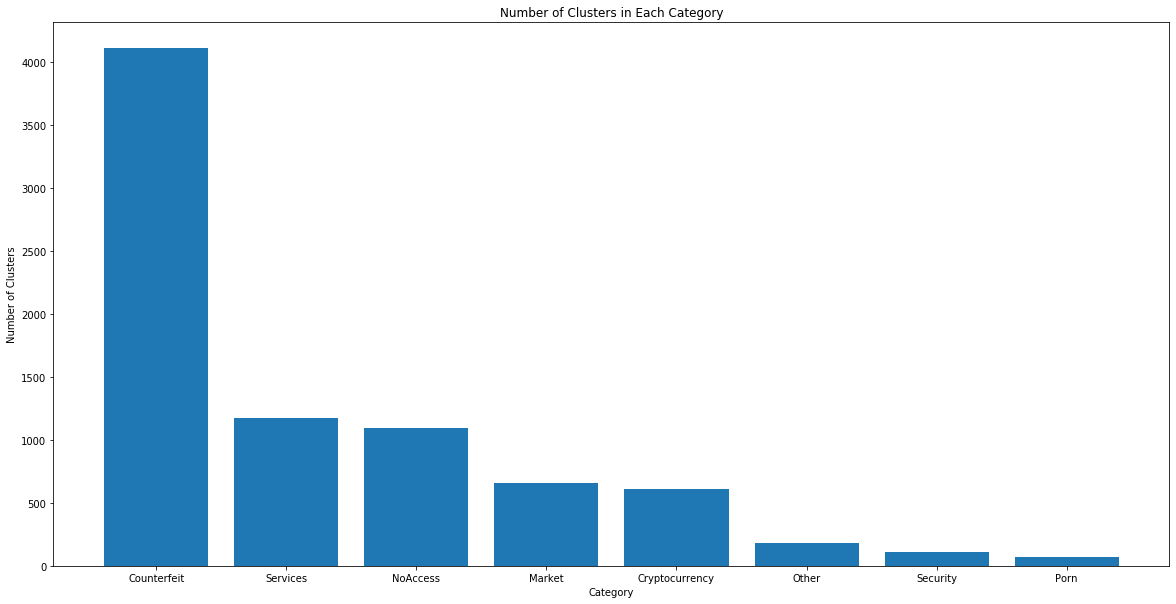

In [7]:
plt.figure(figsize=(20,10))
plt.bar(df_train_count['class'], df_train_count['domain_url'])
plt.xlabel("Category")
plt.ylabel("Number of URLs")
plt.title("Number of URLs in Each Category")
plt.show()

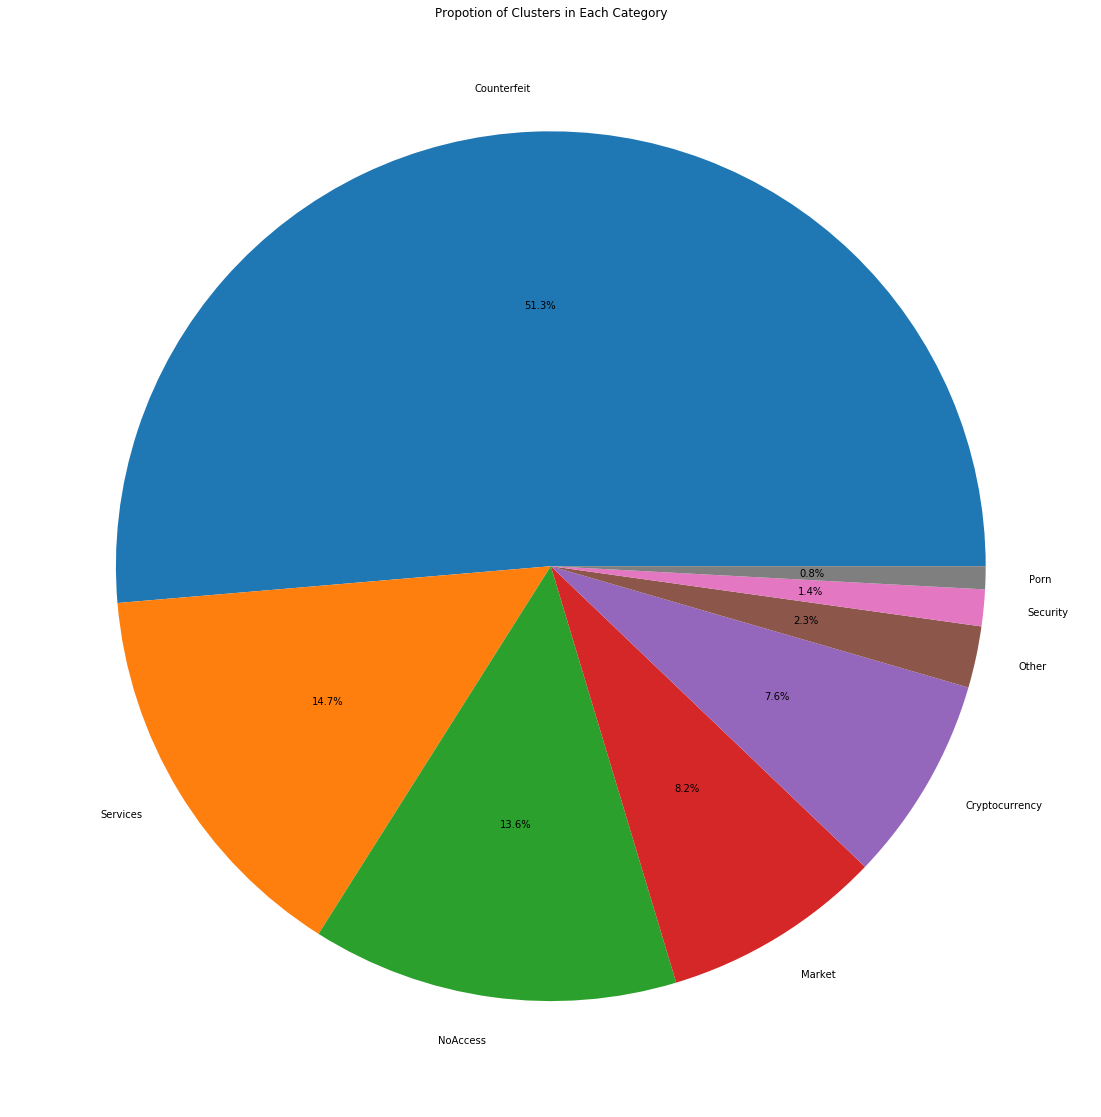

In [8]:
plt.figure(figsize=(20,20))
plt.pie(df_train_count['domain_url'], labels=df_train_count['class'], autopct='%1.1f%%')
plt.title("Propotion of URLs in Each Category")
plt.show()

In [9]:
# Read input data
df_test = pd.read_csv('../data/model_testing_dataset_domain.csv')

# convert the string representation of a list into a list
df_test['body_text'] = df_test['body_text'].apply(ast.literal_eval)
df_test['body_token'] = df_test['body_token'].apply(ast.literal_eval)
df_test['class'] = 'NA'
df_test

,domain_url,title,body_text,body_token,language,class
0,22oxht5ep3hvyboc.onion,Onion Dir - Adult,[Rape Amateur Anal Arab Asian ASMR Ass BBW Zoo...,"[rape, amateur, anal, arab, asian, asmr, bbw, ...",en,NA
1,22pp2nrnjcmtlzja.onion,PayPal Plaza | The Tor Marketplace For Buying ...,[PayPal Plaza The Tor Marketplace For Buying S...,"[paypal, plaza, tor, marketplac, buy, sell, pa...",en,NA
2,2464b3fu462tx2en.onion,CHILD PORN CENTER,"[Chika Club child porn, http 7oodcg4dnetxxegx ...","[chika, club, child, porn, oodcg, dnetxxegx, o...",en,NA
3,24adsavjl3u6tylr.onion,"CP Video HD 2021, PTHC, Loli, child porn, pret...",[Attention the form of payment requires Javasc...,"[attent, form, payment, requir, pleas, enabl, ...",en,NA
4,2ajtkan56n6aiyl6.onion,Hard Porn Forum,[torture man who does not listen and cries wit...,"[tortur, man, doe, listen, cri, chimpanze, enj...",en,NA
...,...,...,...,...,...,...
12130,rkvwooasau2goqeamkqbade4yv2hnt6dc4ol5kgnaaoihd...,Moneys spider - financial pyramid,"[No wallet get it here https www coinbase com,...","[wallet, get, www, coinbas, com, lucki, invit,...",en,NA
12131,e26whn2524322mkxb3cbyk27ev2ihhq2biz35hty7gzgsy...,BenTasker.co.uk - The Home of Ben Tasker - www...,[vepretty broad range of skills all built up t...,"[vepretti, broad, rang, skill, built, experi, ...",en,NA
12132,4vzhn5j644aa523g.onion,Canny,"[Biggest collection with daily updates, Buy th...","[biggest, collect, daili, updat, buy, access, ...",en,NA
12133,cashgodr53umth4z.onion,Cash God - Real Cash Sellers,"[Cash God Real Cash Sellers, We Need Your Help...","[cash, god, real, cash, seller, need, help, co...",en,NA


In [10]:
df_combined = pd.concat([df_train, df_test])
df_combined

,domain_url,title,body_text,body_token,language,class
0,wwjewp6ca4rkudyj.onion,\n Frënn vun der Ënn - Index\n,"[Twitter, Donate, Worldmap, Tor is free softwa...","[twitter, donat, worldmap, tor, softwar, netwo...",en,Services
1,u76xgym22s4adf55.onion,PayPal Master: Home,[Receive within 24 hours tip catch us on Teleg...,"[receiv, hour, tip, catch, telegram, transfer,...",en,Counterfeit
2,elherbotsiddarol.onion,ElHerbolario,"[Thanks for your visit, Anywaywill recommend t...","[thank, visit, recommend, elherbolario, order,...",en,Market
3,yermrrzeg4fusqx5.onion,anonymous OnionMail Server,"[anonymous OnionMail Server, This is an OnionM...","[onionmail, server, thi, onionmail, server, ma...",en,Services
4,safebtck4qejiero.onion,SafePay BTC | Bitcoin Escrow Payment Service,[days is the suggested response time but you m...,"[day, respons, time, day, creat, transact, sel...",en,Cryptocurrency
...,...,...,...,...,...,...
12130,rkvwooasau2goqeamkqbade4yv2hnt6dc4ol5kgnaaoihd...,Moneys spider - financial pyramid,"[No wallet get it here https www coinbase com,...","[wallet, get, www, coinbas, com, lucki, invit,...",en,NA
12131,e26whn2524322mkxb3cbyk27ev2ihhq2biz35hty7gzgsy...,BenTasker.co.uk - The Home of Ben Tasker - www...,[vepretty broad range of skills all built up t...,"[vepretti, broad, rang, skill, built, experi, ...",en,NA
12132,4vzhn5j644aa523g.onion,Canny,"[Biggest collection with daily updates, Buy th...","[biggest, collect, daili, updat, buy, access, ...",en,NA
12133,cashgodr53umth4z.onion,Cash God - Real Cash Sellers,"[Cash God Real Cash Sellers, We Need Your Help...","[cash, god, real, cash, seller, need, help, co...",en,NA


In [11]:
# List of unique labels
L = df_train['class']
L = list(L)
label_set = set(L)
# Encode L as integers
le = preprocessing.LabelEncoder()
le.fit(L)
y = le.transform(L)
ordered_labels = le.inverse_transform([i for i in range(8)])
y

array([7, 0, 2, ..., 7, 0, 3])

In [12]:
# Convert lists of tokens into lists of strings
# Each row represents an url
combined_docs = df_combined['body_token']
combined_docs_string = combined_docs.apply(lambda x: ' '.join(x))
combined_docs_string

0        twitter donat worldmap tor softwar network hel...
1        receiv hour tip catch telegram transfer transf...
2        thank visit recommend elherbolario order track...
3        onionmail server thi onionmail server mail tor...
4        day respons time day creat transact seller has...
                               ...                        
12130    wallet get www coinbas com lucki invit byparti...
12131    vepretti broad rang skill built experi butdeci...
12132    biggest collect daili updat buy access content...
12133    cash god real cash seller need help contact u ...
12134                                       donhav account
Name: body_token, Length: 20137, dtype: object

In [13]:
# Convert lists of tokens into lists of strings
# Each row represents an url
train_docs = df_train['body_token']
train_docs_string = train_docs.apply(lambda x: ' '.join(x))
train_docs_string

0       twitter donat worldmap tor softwar network hel...
1       receiv hour tip catch telegram transfer transf...
2       thank visit recommend elherbolario order track...
3       onionmail server thi onionmail server mail tor...
4       day respons time day creat transact seller has...
                              ...                        
7997    support vcash dogecoin testnet bitsynq contrib...
7998    read celebr year ipv connect view network subm...
7999    owndomain guerrilla mail email arriv domain ac...
8000    gift card transfer account card gift card aust...
8001    power vbulletin version vbulletin reserv zcaro...
Name: body_token, Length: 8002, dtype: object

In [14]:
# Convert lists of tokens into lists of strings
# Each row represents an url
testing_docs = df_test['body_token']
testing_docs_string = testing_docs.apply(lambda x: ' '.join(x))
testing_size = testing_docs_string.shape[0]
testing_docs_string

0        rape amateur anal arab asian asmr bbw zoo bi b...
1        paypal plaza tor marketplac buy sell paypal ac...
2        chika club child porn oodcg dnetxxegx onion be...
3        attent form payment requir pleas enabl tempora...
4        tortur man doe listen cri chimpanze enjoy hard...
                               ...                        
12130    wallet get www coinbas com lucki invit byparti...
12131    vepretti broad rang skill built experi butdeci...
12132    biggest collect daili updat buy access content...
12133    cash god real cash seller need help contact u ...
12134                                       donhav account
Name: body_token, Length: 12135, dtype: object

In [15]:
# Convert lists of strings into tf-idf vectors
tfidf_vect = TfidfVectorizer(strip_accents='ascii', stop_words='english', min_df=3)
vectorizer = tfidf_vect.fit(combined_docs_string)
C_tfidf = vectorizer.transform(train_docs_string)

# Train test split
C_train, C_test, y_train, y_test ,indices_train, indices_test= train_test_split(C_tfidf, y, df_train.index, random_state = 0)

In [16]:
# Fit ensembled models and predict

In [17]:
# Fit a Linear SVC model
linearsvc = LinearSVC()
linearsvc.fit(C_train, y_train)
# Predict test set
y_predict_lsvc = linearsvc.predict(C_test)
# Print accuracy
print("Linear SVC accuracy: ", accuracy_score(y_test, y_predict_lsvc))

Linear SVC accuracy:  0.9615192403798101


In [18]:
# Show scores for each category
print(classification_report(y_test, y_predict_lsvc, target_names=ordered_labels))

                precision    recall  f1-score   support

   Counterfeit       0.99      1.00      1.00      1025
Cryptocurrency       0.99      0.98      0.98       141
        Market       0.99      0.95      0.97       176
      NoAccess       0.90      0.97      0.93       279
         Other       0.86      0.50      0.63        50
          Porn       0.93      0.82      0.87        17
      Security       1.00      0.75      0.86        32
      Services       0.89      0.94      0.91       281

      accuracy                           0.96      2001
     macro avg       0.94      0.86      0.89      2001
  weighted avg       0.96      0.96      0.96      2001



In [19]:
# Fit a SVC model
svc = SVC()
svc.fit(C_train, y_train)
# Predict test set
y_predict_svc = svc.predict(C_test)
# Print accuracy
print("SVC accuracy: ", accuracy_score(y_test, y_predict_svc))

SVC accuracy:  0.9525237381309345


In [20]:
# Show scores for each category
print(classification_report(y_test, y_predict_svc, target_names=ordered_labels))

                precision    recall  f1-score   support

   Counterfeit       1.00      1.00      1.00      1025
Cryptocurrency       1.00      0.96      0.98       141
        Market       1.00      0.93      0.96       176
      NoAccess       0.99      0.91      0.95       279
         Other       0.87      0.40      0.55        50
          Porn       1.00      0.59      0.74        17
      Security       1.00      0.69      0.81        32
      Services       0.76      0.99      0.86       281

      accuracy                           0.95      2001
     macro avg       0.95      0.81      0.86      2001
  weighted avg       0.96      0.95      0.95      2001



In [21]:
# Fit a Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(C_train, y_train)
# Predict test set
y_predict_log = log_reg.predict(C_test)
# Print accuracy
print("Logistic Regression accuracy: ", accuracy_score(y_test, y_predict_log))

Logistic Regression accuracy:  0.952023988005997


In [22]:
# Show scores for each category
print(classification_report(y_test, y_predict_log, target_names=ordered_labels))

                precision    recall  f1-score   support

   Counterfeit       0.99      1.00      0.99      1025
Cryptocurrency       1.00      0.98      0.99       141
        Market       1.00      0.93      0.96       176
      NoAccess       0.92      0.94      0.93       279
         Other       1.00      0.38      0.55        50
          Porn       1.00      0.59      0.74        17
      Security       1.00      0.62      0.77        32
      Services       0.81      0.95      0.88       281

      accuracy                           0.95      2001
     macro avg       0.97      0.80      0.85      2001
  weighted avg       0.96      0.95      0.95      2001



In [23]:
# Fit a XGBoost model
xgb = XGBClassifier()
xgb.fit(C_train, y_train)
# Predict test set
y_predict_xgb = xgb.predict(C_test)
# Print accuracy
print("XGBoost Classifier accuracy: ", accuracy_score(y_test, y_predict_xgb))

XGBoost Classifier accuracy:  0.9505247376311844


In [24]:
# Show scores for each category
print(classification_report(y_test, y_predict_xgb, target_names=ordered_labels))

                precision    recall  f1-score   support

   Counterfeit       0.99      1.00      0.99      1025
Cryptocurrency       0.97      0.96      0.96       141
        Market       0.98      0.93      0.96       176
      NoAccess       0.91      0.95      0.93       279
         Other       0.83      0.40      0.54        50
          Porn       1.00      0.65      0.79        17
      Security       0.92      0.75      0.83        32
      Services       0.84      0.94      0.89       281

      accuracy                           0.95      2001
     macro avg       0.93      0.82      0.86      2001
  weighted avg       0.95      0.95      0.95      2001



In [25]:
# Create a dictionary of our models
# estimators=[('linearsvc', linearsvc), ('svc', svc), ('log_reg', log_reg), ('xgb', xgb)]
estimators=[('linearsvc', linearsvc), ('log_reg', log_reg), ('xgb', xgb)]
# Only include Linear SVC
# estimators=[('linearsvc', linearsvc)]
# Create our voting classifier, inputting our models
ensemble = StackingClassifier(estimators, final_estimator=linearsvc, cv=10)
# Fit model to training data
ensemble.fit(C_train, y_train)
# Predict test set
y_predict_en = ensemble.predict(C_test)
# Print accuracy
print("Ensembled model accuracy: ", accuracy_score(y_test, y_predict_en))

Ensembled model accuracy:  0.9630184907546226


In [26]:
# Show scores for each category
print(classification_report(y_test, y_predict_en, target_names=ordered_labels))

                precision    recall  f1-score   support

   Counterfeit       0.99      1.00      1.00      1025
Cryptocurrency       1.00      0.98      0.99       141
        Market       0.98      0.95      0.97       176
      NoAccess       0.92      0.96      0.94       279
         Other       0.89      0.50      0.64        50
          Porn       0.94      0.88      0.91        17
      Security       1.00      0.75      0.86        32
      Services       0.88      0.94      0.91       281

      accuracy                           0.96      2001
     macro avg       0.95      0.87      0.90      2001
  weighted avg       0.96      0.96      0.96      2001



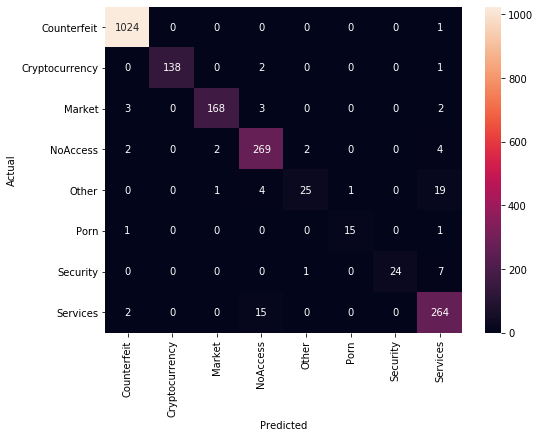

In [27]:
ticklabels = le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7])
conf_mat = confusion_matrix(y_test, y_predict_en)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=ticklabels, yticklabels=ticklabels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [28]:
wrong_pred_threshold = 5
label_id = [0, 1, 2, 3, 4, 5, 6, 7]
from IPython.display import display
for predicted in label_id:
    for actual in label_id:
        if predicted != actual and conf_mat[actual, predicted] >= wrong_pred_threshold:
            print("'{}' predicted as '{}' : {} examples.".format(le.inverse_transform([actual])[0], le.inverse_transform([predicted])[0], conf_mat[actual, predicted]))
            display(df_train.loc[indices_test[(y_test == actual) & (y_predict_en == predicted)]][['class', 'body_text']])
            print('')

'Services' predicted as 'NoAccess' : 15 examples.


,class,body_text
558,Services,"[Publicit Communication, Install parIT Crowd R..."
3725,Services,[This includes dedicated servers offline playa...
4106,Services,[LogandCMS is modular software and can be cust...
295,Services,[USK RqZqFR0fOwQ0OQKG3wUn1jjJWiTm5BXoVFpU1YIAg...
311,Services,"[Once Delete the message when itread, CryptoJS..."
2923,Services,"[Richard Harris Biography IMDb, Norway, There ..."
557,Services,[Released in 1970 though not included on YesTi...
6841,Services,[What is Laundering asservice Modified from th...
194,Services,"[Time Conversion, PasswordGen Backwards Base 3..."
4105,Services,[LogandCMS is modular software and can be cust...



'Other' predicted as 'Services' : 19 examples.


,class,body_text
162,Other,[like to welcome you to the HSTrierplace where...
233,Other,"[Iton TOR, Just find it out]"
72,Other,[microblogging wowaname anime website onion i2...
7998,Other,[Read more about Celebration 10 years IPv6 con...
651,Other,[solution was going well on it and that there ...
4766,Other,"[Buyer help, Vendor announcements news and upd..."
2588,Other,[When August 15th 2003 19 00 21 00 key signing...
613,Other,"[and, Open Source Rats, Find me on, Hiam Hoek ..."
7027,Other,"[Collections, Authors, Radical Militant Librar..."
191,Other,[Note that the classifier is only allowed to l...



'Security' predicted as 'Services' : 7 examples.


,class,body_text
4418,Security,[Subscribe to our newsletter and stay updated ...
210,Security,[Features Delayed Start Delayed Encryption Mut...
3724,Security,[You can either send the video clip directly v...
7107,Security,[The Tin Hat Tutorials All Add ons Alternative...
2994,Security,[With Exbits proper use of social media it can...
472,Security,[Do not rely on the negative criticism rumors ...
3711,Security,[There are examples beyond count throughout hu...


In [29]:
# Convert lists of strings into tf-idf vectors
C_testing_tfidf = vectorizer.transform(testing_docs_string)

In [30]:
# Predict on testing data
y_testing_predict_en = ensemble.predict(C_testing_tfidf)

In [31]:
df_test['predicted_class'] = le.inverse_transform(y_testing_predict_en)
df_test.drop(columns=['class'], inplace=True)
df_test['verified_class'] = df_test['predicted_class']
df_test

,domain_url,title,body_text,body_token,language,predicted_class,verified_class
0,22oxht5ep3hvyboc.onion,Onion Dir - Adult,[Rape Amateur Anal Arab Asian ASMR Ass BBW Zoo...,"[rape, amateur, anal, arab, asian, asmr, bbw, ...",en,Porn,Porn
1,22pp2nrnjcmtlzja.onion,PayPal Plaza | The Tor Marketplace For Buying ...,[PayPal Plaza The Tor Marketplace For Buying S...,"[paypal, plaza, tor, marketplac, buy, sell, pa...",en,Counterfeit,Counterfeit
2,2464b3fu462tx2en.onion,CHILD PORN CENTER,"[Chika Club child porn, http 7oodcg4dnetxxegx ...","[chika, club, child, porn, oodcg, dnetxxegx, o...",en,Porn,Porn
3,24adsavjl3u6tylr.onion,"CP Video HD 2021, PTHC, Loli, child porn, pret...",[Attention the form of payment requires Javasc...,"[attent, form, payment, requir, pleas, enabl, ...",en,Porn,Porn
4,2ajtkan56n6aiyl6.onion,Hard Porn Forum,[torture man who does not listen and cries wit...,"[tortur, man, doe, listen, cri, chimpanze, enj...",en,Porn,Porn
...,...,...,...,...,...,...,...
12130,rkvwooasau2goqeamkqbade4yv2hnt6dc4ol5kgnaaoihd...,Moneys spider - financial pyramid,"[No wallet get it here https www coinbase com,...","[wallet, get, www, coinbas, com, lucki, invit,...",en,NoAccess,NoAccess
12131,e26whn2524322mkxb3cbyk27ev2ihhq2biz35hty7gzgsy...,BenTasker.co.uk - The Home of Ben Tasker - www...,[vepretty broad range of skills all built up t...,"[vepretti, broad, rang, skill, built, experi, ...",en,Services,Services
12132,4vzhn5j644aa523g.onion,Canny,"[Biggest collection with daily updates, Buy th...","[biggest, collect, daili, updat, buy, access, ...",en,Porn,Porn
12133,cashgodr53umth4z.onion,Cash God - Real Cash Sellers,"[Cash God Real Cash Sellers, We Need Your Help...","[cash, god, real, cash, seller, need, help, co...",en,Counterfeit,Counterfeit


In [32]:
df_test.to_csv('../data/model_testing_dataset_domain_predicted.csv', index=False)

In [33]:
df_test.drop(columns=['verified_class'], inplace=True)
df_test.rename(columns={'predicted_class': 'class'}, inplace=True)
df_predicted_combined = pd.concat([df_train, df_test])

# Count number of clusters in each category
df_predicted_combined_count = df_predicted_combined[['domain_url', 'class']].groupby(['class']).count()
df_predicted_combined_count = df_predicted_combined_count.sort_values(by=['domain_url'], ascending=False)
df_predicted_combined_count.reset_index(inplace=True)
df_predicted_combined_count

,class,domain_url
0,Counterfeit,9438
1,Services,3215
2,NoAccess,2285
3,Cryptocurrency,2217
4,Market,1290
5,Porn,996
6,Other,447
7,Security,249


In [34]:
df_predicted_combined

,domain_url,title,body_text,body_token,language,class
0,wwjewp6ca4rkudyj.onion,\n Frënn vun der Ënn - Index\n,"[Twitter, Donate, Worldmap, Tor is free softwa...","[twitter, donat, worldmap, tor, softwar, netwo...",en,Services
1,u76xgym22s4adf55.onion,PayPal Master: Home,[Receive within 24 hours tip catch us on Teleg...,"[receiv, hour, tip, catch, telegram, transfer,...",en,Counterfeit
2,elherbotsiddarol.onion,ElHerbolario,"[Thanks for your visit, Anywaywill recommend t...","[thank, visit, recommend, elherbolario, order,...",en,Market
3,yermrrzeg4fusqx5.onion,anonymous OnionMail Server,"[anonymous OnionMail Server, This is an OnionM...","[onionmail, server, thi, onionmail, server, ma...",en,Services
4,safebtck4qejiero.onion,SafePay BTC | Bitcoin Escrow Payment Service,[days is the suggested response time but you m...,"[day, respons, time, day, creat, transact, sel...",en,Cryptocurrency
...,...,...,...,...,...,...
12130,rkvwooasau2goqeamkqbade4yv2hnt6dc4ol5kgnaaoihd...,Moneys spider - financial pyramid,"[No wallet get it here https www coinbase com,...","[wallet, get, www, coinbas, com, lucki, invit,...",en,NoAccess
12131,e26whn2524322mkxb3cbyk27ev2ihhq2biz35hty7gzgsy...,BenTasker.co.uk - The Home of Ben Tasker - www...,[vepretty broad range of skills all built up t...,"[vepretti, broad, rang, skill, built, experi, ...",en,Services
12132,4vzhn5j644aa523g.onion,Canny,"[Biggest collection with daily updates, Buy th...","[biggest, collect, daili, updat, buy, access, ...",en,Porn
12133,cashgodr53umth4z.onion,Cash God - Real Cash Sellers,"[Cash God Real Cash Sellers, We Need Your Help...","[cash, god, real, cash, seller, need, help, co...",en,Counterfeit


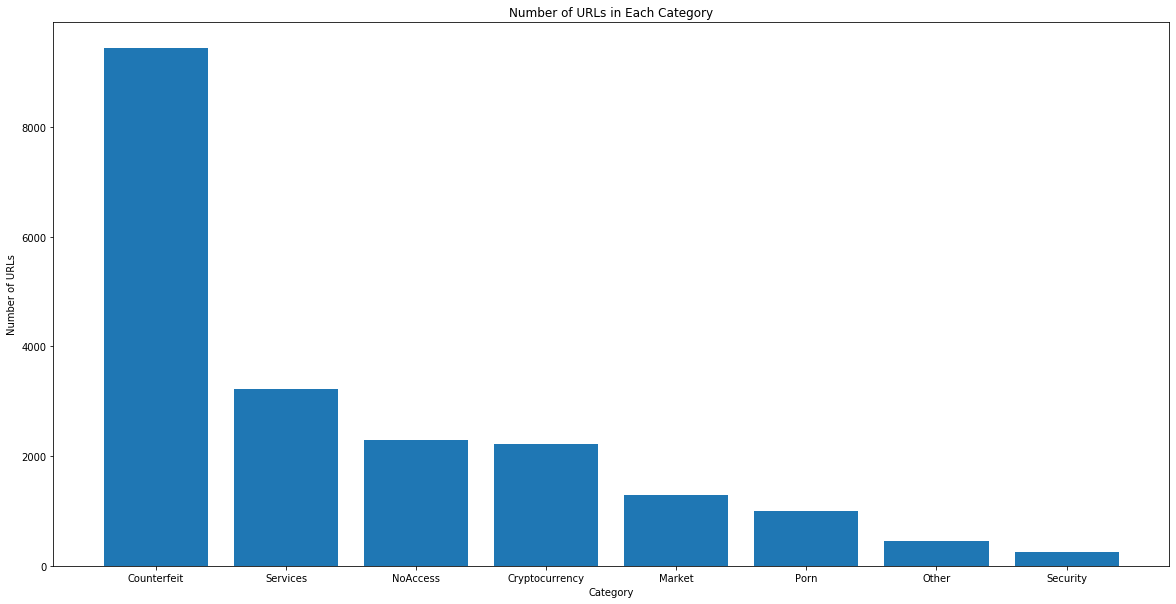

In [37]:
plt.figure(figsize=(20,10))
plt.bar(df_predicted_combined_count['class'], df_predicted_combined_count['domain_url'])
plt.xlabel("Category")
plt.ylabel("Number of URLs")
plt.title("Number of URLs in Each Category")
plt.show()

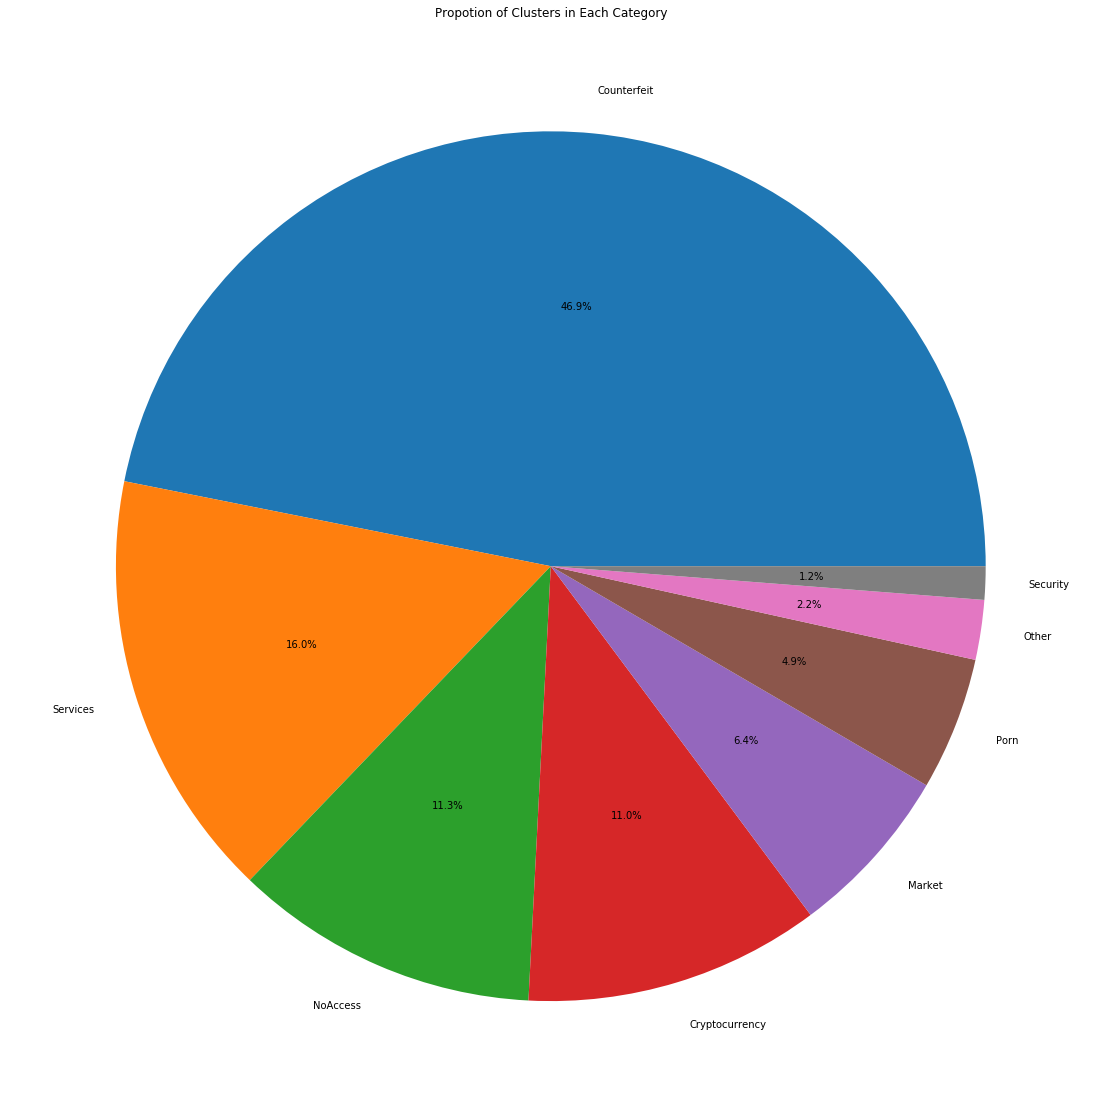

In [36]:
plt.figure(figsize=(20,20))
plt.pie(df_predicted_combined_count['domain_url'], labels=df_predicted_combined_count['class'], autopct='%1.1f%%')
plt.title("Propotion of URLs in Each Category")
plt.show()